# An Analysis of Wine Production, Consumption, Ratings and Price

### Part I - Historical Data Analyses
* Global Production and Consumption vs. Population Growth
* Historical Production, Export and Consumption for the top 10 producers in 2016
* Focus on the US

### Part II - Analyses of Ratings, Varieties, Origin and Price
* Blah
* Blah
* Blah
* Blah

In [126]:
#%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
import requests
import json
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import plot

from api_keys import (owmkey,gkey)
reportimagepath='../reports/images/'

## Part I - Analyzing global historial wine trade (Working on Giant MS-Excel File)¶
-Database source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), Annual Database of Global Wine Markets, 1835 to 2016, freely available in Excel at the University of Adelaide’s Wine Economics Research Centre, November 2017 www.adelaide.edu.au/wine-econ/databases/global-wine-history

#### The source file has over 100 sheets. For this study we used:
* T6 Volume of wine production
* T8 Volume of wine production per capita
* T10 Volume of wine exports
* T12 Volume of wine exports per capita
* T15 Volume of wine imports
* T17 Volume of wine imports per capita
* T34 Volume of wine consumption
* T38 Volume of wine consumption per capita
* T58 Population

### Data Wrangling

#### The follwoing function works as follows:
* Reads the name of worksheet within the giant Excel Worksheet (string) (required)
* Reads the number of rows to be removed from bottom (brr) and top (thr) (two integers) (optional)
* Removes unnecessary columns (e.g. Other column, Other Asia Pacific, Coeff. of variation)
* Relocate/Rename columns (i.e., Norway and Bel-Lux)
* Takes the year column as index
* Returns the cleaned dataframe with the year as index

In [4]:
# removing the unnecessary row from top or bottom
# relocating the columns and removing unnecessary ones
# reset indexing
def giant_worksheet(sheet_giant,brr=0, thr=0):
    
    df = pd.read_excel('../data/rawdata/Megafile_of_global_wine_data_1835_to_2016_1217.xlsx', 
                         sheet_name=sheet_giant, header=1, index_col=None)
    df.index.rename('year',inplace=True)
    df=df.reset_index()
    df.fillna(-1,inplace=True) #fills empty cells with -1
    
    #relocating the Norway column if exist
    try:
        nor = df['Norway']
        df.drop(labels=['Norway'], axis=1,inplace = True)
        df.insert(6, 'Norway', nor)
    except:
        print('NO Norway column found in worksheet:', sheet_giant)

    #dfmf.drop(labels=['nan'], axis=1,inplace = True)
    df=df.rename(columns={'Bel-Lux':'Belgium'}) #chnage the name of Be-Lux to Belgium
    df.drop(labels=['Coeff. of variation'], axis=1,inplace = True) #remove the coeff of var column.
    df.drop(labels=['Other'], axis=1,inplace = True) #remove the Other column
    df.drop(labels=['Other Asia Pacific'], axis=1,inplace = True) #remove the Other column
    #df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

    row_to_drop=list(range(thr))
    df=df.drop(df.index[row_to_drop])
    if brr !=0:
        df=df[:-brr]
    df.set_index('year',inplace=True)
    print('Worksheet: {} wrangling completed!'.format(sheet_giant))
    return df

Pass each worksheet to the giant_worksheet function and save the dataframe to a worksheet of a MS-Excel Workbook called Wine_History.xlsx

In [5]:
outputpath="..\data\cleandata\Wine_History.xlsx"
writer = pd.ExcelWriter(outputpath, engine='xlsxwriter')


#Wine production volume(dfwpv) (KL) (ws #6)
sheetname='T6 Wine production'
dfwpv=giant_worksheet(sheet_giant=sheetname,thr=30)
dfwpv.to_excel(writer, sheet_name=sheetname)

#wine production per capita (dfwppc) (litres) (ws #8)
sheetname='T8 Wine prodn per capita'
dfwppc=giant_worksheet(sheet_giant=sheetname,thr=30,brr=3)
dfwppc.to_excel(writer, sheet_name=sheetname)

#wine production per capita (dfwev) (KL) (ws #10)
sheetname='T10 Wine export vol'
dfwev=giant_worksheet(sheet_giant=sheetname,thr=30,brr=3)
dfwev.to_excel(writer, sheet_name=sheetname)

#Wine import volume(dfwiv) (KL) (ws #15)
sheetname='T15 Wine import vol'
dfwiv=giant_worksheet(sheet_giant=sheetname,thr=30)
dfwiv.to_excel(writer, sheet_name=sheetname)

#Wine consumption volume(dfwcv) (KL) (ws #34)
sheetname='T34 Wine consumption vol'
dfwcv=giant_worksheet(sheet_giant=sheetname,thr=30)
dfwcv.to_excel(writer, sheet_name=sheetname)

#Wine consumption per capita (dfwcpc) (litres) (ws #38)
sheetname='T38 Wine consumption per capita'
dfwcpc=giant_worksheet(sheet_giant=sheetname,thr=30)
dfwcpc.to_excel(writer, sheet_name=sheetname)

#Global population (dfgp) (*1000) (ws #58)
sheetname='T58 Population'
dfgp=giant_worksheet(sheet_giant=sheetname,thr=30)
dfgp.to_excel(writer, sheet_name=sheetname)


#Wine consumption intensity index (dfwcii) (ws #96)
sheetname='T96 Wine cons intensity index'
dfwcii=giant_worksheet(sheet_giant=sheetname, brr=15,thr=126)
dfwcii.to_excel(writer, sheet_name=sheetname)

writer.save()

sheeet T34 Wine consumption vol wrangling completed!
NO Norway column found in worksheet: T6 Wine production
sheeet T6 Wine production wrangling completed!
sheeet T96 Wine cons intensity index wrangling completed!
sheeet T38 Wine consumption per capita wrangling completed!
NO Norway column found in worksheet: T8 Wine prodn per capita
sheeet T8 Wine prodn per capita wrangling completed!
sheeet T58 Population wrangling completed!


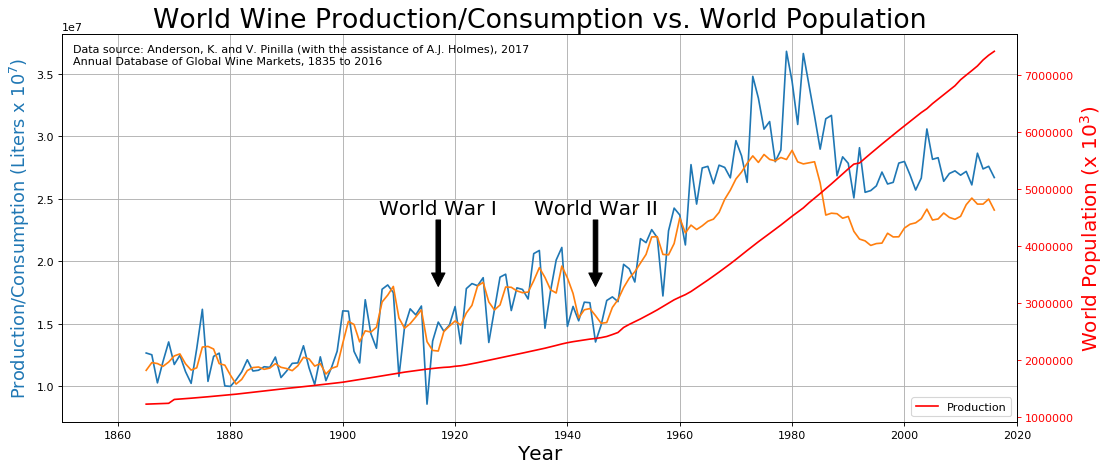

In [127]:
# --------------------------------------------------------------------
# Plotting World Production and World population 1850-2016
# --------------------------------------------------------------------

# World production in volume

# Main plot: global production and consumption
fig, ax1 = plt.subplots(figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
l1=ax1.plot(dfwpv.index,dfwpv.World, color='#1f77b4')
l2=ax1.plot(dfwcv.index,dfwcv.World, color='#ff7f0e')

ax1.grid()
# Arrows 
ax1.annotate('World War I', xy=(1917, 18000000), xycoords='data', xytext=(1917, 25000000), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=1),
            horizontalalignment='center', verticalalignment='top',fontsize=18)
ax1.annotate('World War II', xy=(1945, 18000000), xycoords='data', xytext=(1945, 25000000), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=1),
            horizontalalignment='center', verticalalignment='top',fontsize=18)
# Labels
ax1.set_xlabel('Year',fontsize=18)
ax1.set_ylabel('Production/Consumption (Liters x $10^7$)', color='#1f77b4',fontsize=16)

#plt.legend(["Production","Consumption"],loc="lower right")

# twinx allows to add data to the main plot, with the same x, but a different y scale
ax2 = ax1.twinx()
ax2.plot(dfgp.index,dfgp.World, color='r')
ax2.set_ylabel('World Population (x $10^3$)', color='r',fontsize=18)
ax2.tick_params('y', colors='r')

# Final plot title and x adjustment
plt.title("World Wine Production/Consumption vs. World Population",fontsize=24)
plt.xlim(left = 1850, right=2020)
# Required acknowledgement to the source
plt.text(1852,7200000,"Data source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), 2017\nAnnual Database of Global Wine Markets, 1835 to 2016")

#legend
plt.legend(["Production","Consumption"],loc="lower right")
fig.tight_layout()

# Output plot file
plt.savefig(reportimagepath+"01 World Wine Production and Consumption vs World Population.png",bbox_inches="tight")

plt.show()

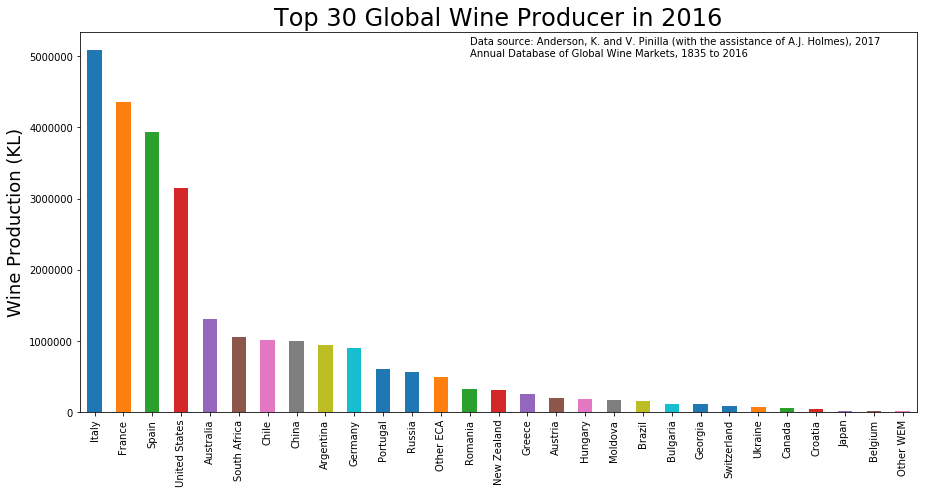

In [128]:
# --------------------------------------------------------------------
# Plotting Top 30 Global Wine Producers in 2016
# --------------------------------------------------------------------

ax3=dfwpv.loc[2016].sort_values(ascending=False)[1:30].plot(kind='bar',figsize=(15,7))
plt.title("Top 30 Global Wine Producer in 2016", fontsize=24)
# Required acknowledgement to the source
plt.text(13,5000000,"Data source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), 2017\nAnnual Database of Global Wine Markets, 1835 to 2016")
ax3.set_ylabel("Wine Production (KL)",fontsize=18)
fig.tight_layout()

# Output plot file
plt.savefig(reportimagepath+"02 Wine Production by Volume - Top 30 Producing Countries.png",bbox_inches="tight")

This function reads the dataframe, chart title, and y-axis label, and return the plot for the list of countries

In [117]:
def wine_pc(fignum,df,countries, title, yax_name):
    # Comparison of Historical Wine Production per Capita for top 10 producers
    #Top 10 wine producer in 2016
    fig, ax1 = plt.subplots(figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
    for x in countries:
        ax1.plot(df.index,df[x])

    plt.ylim(top=max(df[x].max() for x in countries)*1.2)
    plt.title(title+'- Top 10 Producing Countries',fontsize=24)
    plt.xlabel("Year",fontsize=18)
    plt.ylabel(yax_name,fontsize=18)
    plt.text(min(df.index),max(df[x].max() for x in countries)*1.1,"Data source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), 2017\nAnnual Database of Global Wine Markets, 1835 to 2016")
    plt.legend()

    # Output plot file
    plt.savefig("../reports/images/"+str(fignum)+'-'+title+'.png',bbox_inches="tight")

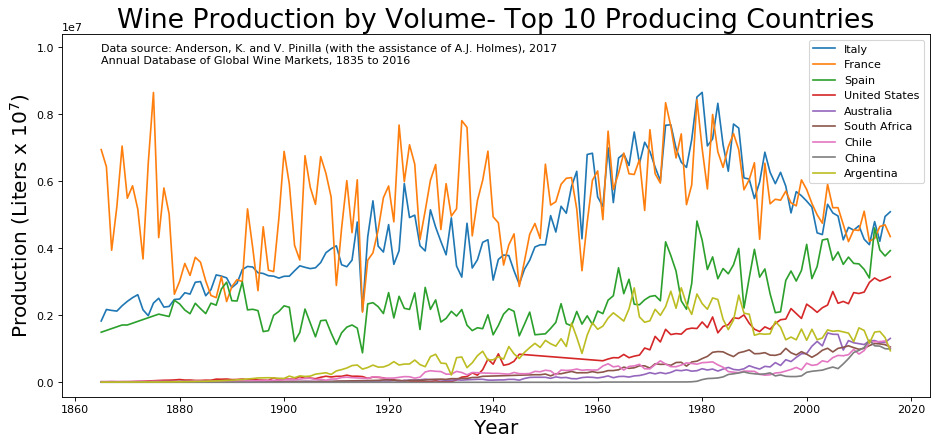

In [129]:
# Comparison of Historical Wine Production for top 10 producers

#Top 10 wine producer in 2016
countries=dfwpv.loc[2016].sort_values(ascending=False)[1:10].index

# Wine production volume
wine_pc(3,dfwpv, countries, "Wine Production by Volume",'Production (Liters x $10^7$)')


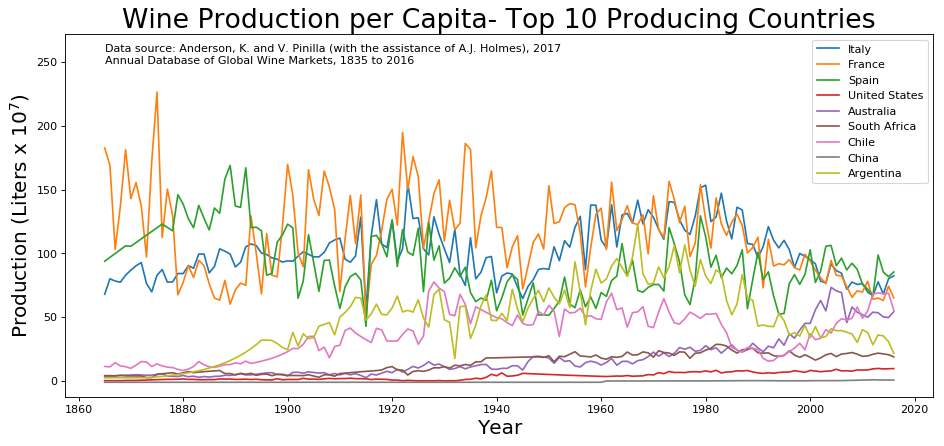

In [130]:
# Wine production per capita
wine_pc(4, dfwppc, countries, "Wine Production per Capita",'Production (Liters x $10^7$)')

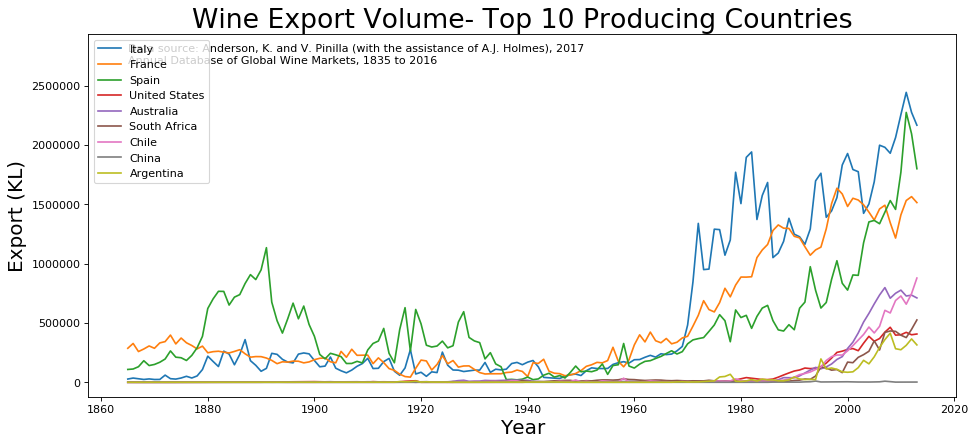

In [131]:
# Comparison of Wine Export Volumes for the top 10 producers
wine_pc(5, dfwev, countries, "Wine Export Volume","Export (KL)")

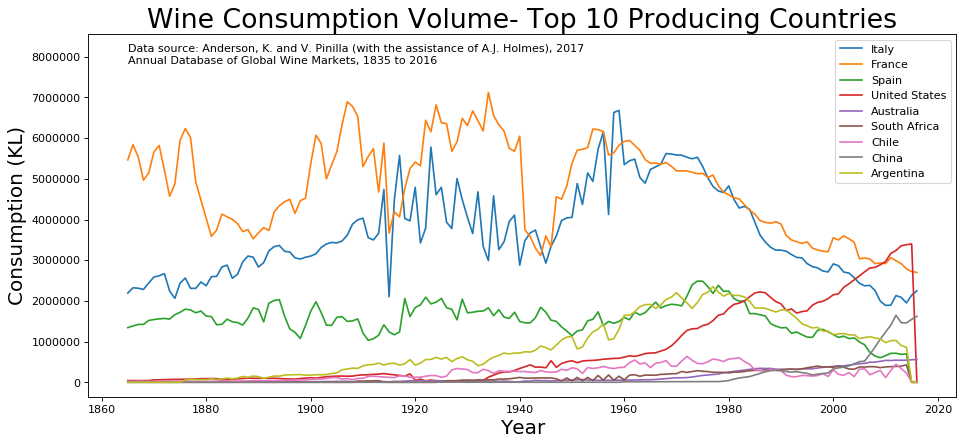

In [132]:
# Comparison of Wine Consumption for the top 10 producers
wine_pc(6, dfwcv, countries, "Wine Consumption Volume","Consumption (KL)")

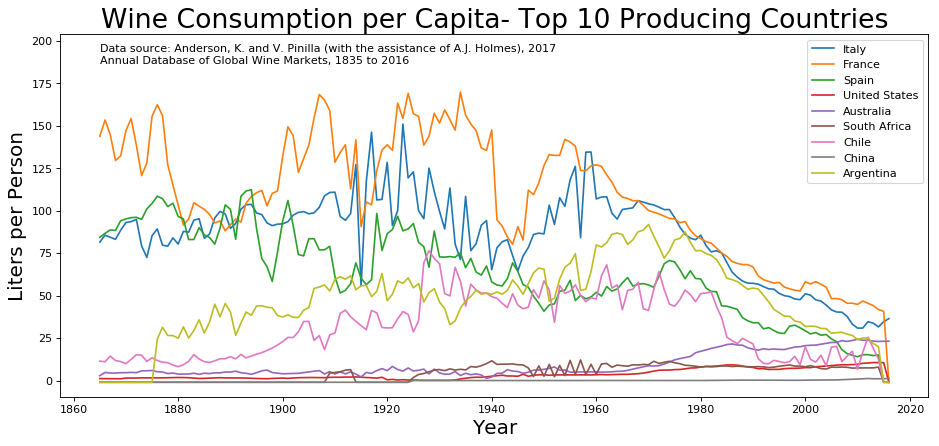

In [135]:
# Comparison of Wine Consumption per capita for the top 10 producers
wine_pc(7, dfwcpc, countries, "Wine Consumption per Capita","Liters per Person")

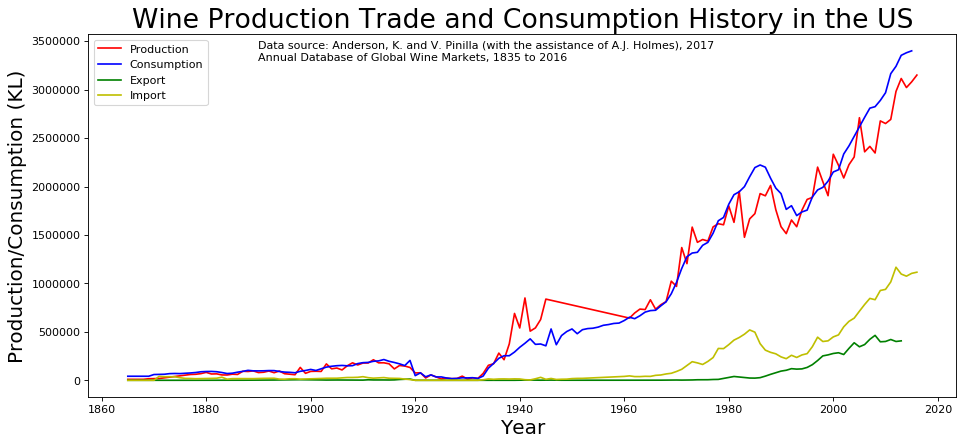

In [150]:
# =============
# = US only:  =
# =============

x='United States'
title='Wine Production Trade and Consumption History in the US'
fig, ax1 = plt.subplots(figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
l1=ax1.plot(dfwpv.index,dfwpv[x],color='r')
l2=ax1.plot(dfwcv.index,dfwcv[x],color='b')
l3=ax1.plot(dfwev.index,dfwev[x],color='g')
l4=ax1.plot(dfwiv.index,dfwiv[x],color='y')

#plt.ylim(top=max(df[x].max() for x in countries)*1.2)
plt.title(title,fontsize=24)
plt.xlabel("Year",fontsize=18)
plt.ylabel('Production/Consumption (KL)',fontsize=18)
plt.text(1890,3300000,"Data source: Anderson, K. and V. Pinilla (with the assistance of A.J. Holmes), 2017\nAnnual Database of Global Wine Markets, 1835 to 2016")
plt.legend(["Production","Consumption","Export","Import"],loc='best')

# Output plot file
plt.savefig("../reports/images/"+str(8)+title+".png",bbox_inches="tight")

plt.show()